## Bayesian Neural Networks in Keras and TensorFlow 1.14

In [35]:
#TODO: PUT RANDOM SEED FOR RESULT SECURING IN DEMOS
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
tfd = tfp.distributions

In [36]:
print('TensorFlow version (expected = 1.14.0):', tf.__version__)
print('TensorFlow Probability version (expected = 0.9.0-dev20190912):', tfp.__version__)
#trying to make it work with this version, as the nightly one does not import here

TensorFlow version (expected = 1.14.0): 1.14.0
TensorFlow Probability version (expected = 0.9.0-dev20190912): 0.7.0


In [10]:
def softmax(X, theta = 1.0, axis = None):
    """
    Compute the softmax of each element along an axis of X.

    Parameters
    ----------
    X: ND-Array. Probably should be floats.
    theta (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
    axis (optional): axis to compute values along. Default is the
        first non-singleton axis.

    Returns an array the same size as X. The result will sum to 1
    along the specified axis.
    """

    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    # multiply y against the theta parameter,
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis = axis), axis)

    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()

    return p

## We are all set up, lets go!

We are using MNIST dataset!
X_train.shape = (60000, 28, 28, 1)
y_train.shape = (60000, 10)
X_test.shape = (10000, 28, 28, 1)
y_test.shape = (10000, 10)


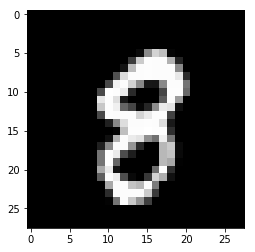

In [11]:
"""
first, we load the dataset. We are trying to do it first with MNIST
I've found this snippet somewhere in github
"""

#as we have 10 classes, I'm setting class number to 10
class_nmr = 10

print('We are using MNIST dataset!')
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = np.expand_dims(X_train, -1)
n_train = X_train.shape[0]
X_test = np.expand_dims(X_test, -1)
y_train = tf.keras.utils.to_categorical(y_train, class_nmr)
y_test = tf.keras.utils.to_categorical(y_test, class_nmr)

# Normalize data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_test.shape =", X_test.shape)
print("y_test.shape =", y_test.shape)

plt.imshow(X_train[1026, :, :, 0], cmap='gist_gray')

In [24]:
class BCNN:
    def __init__(self):
        self._build_model()
        
    def _build_model(self):
        self.model_in = tf.placeholder(shape=[None,28,28,1], dtype="float32")
        self.labels = tf.placeholder(shape=[None,10], dtype="float32")
        
        self.conv_1 = tfp.python.layers.Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2)
        self.x = self.conv_1(self.model_in)
        self.x = tf.keras.layers.BatchNormalization()(self.x)
        self.x = tf.keras.layers.Activation('relu')(self.x)
        self.conv_2 = tfp.python.layers.Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2)
        self.x = self.conv_2(self.x)
        self.x = tf.keras.layers.BatchNormalization()(self.x)
        self.x = tf.keras.layers.Activation('relu')(self.x)
        self.x = tf.keras.layers.Flatten()(self.x)
        self.dense_1 = tfp.python.layers.DenseFlipout(512, activation='relu')
        self.x = self.dense_1(self.x)
        self.dense_2 = tfp.python.layers.DenseFlipout(10, activation=None)
        self.preds = self.dense_2(self.x)  # logits
        
        self.loss_en = tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.preds)
        self.loss_kl = tf.keras.losses.KLD(self.labels, self.preds) 
        self.loss = tf.reduce_mean(tf.add(self.loss_en, self.loss_kl))

        self.optimizer = tf.train.AdamOptimizer(0.01)
        self.train_op = self.optimizer.minimize(self.loss)
        
    def predict(self, sess, X):
        return sess.run(self.preds, { self.model_in: X })
    
    def update(self, sess, x, y):
        feed_dict = { self.model_in: x, self.labels: y }
        _, loss = sess.run(
            [self.train_op, self.loss],
            feed_dict)
        return loss
    
    

In [25]:
bcnn = BCNN()

In [34]:
with tf.Session() as sess:   
    sess.run(tf.global_variables_initializer())
    for i in range(20):
        loss = bcnn.update(x=X_train, sess=sess, y=y_train)
        #print(loss)
        preds = bcnn.predict(sess, X_train)
        acc = accuracy(preds, y_train)
        print("Epoch: {}: loss = {} , accuracy = {}".format(i, loss, acc))

Epoch: 22: loss = 9.74981689453125 , accuracy = 0.13398333333333334
Epoch: 23: loss = 15.528031349182129 , accuracy = 0.14601666666666666
Epoch: 24: loss = 8.114693641662598 , accuracy = 0.14813333333333334
Epoch: 25: loss = 6.095821857452393 , accuracy = 0.1594
Epoch: 26: loss = 4.190555095672607 , accuracy = 0.11913333333333333
Epoch: 27: loss = 4.154258728027344 , accuracy = 0.11366666666666667
Epoch: 28: loss = 3.0169458389282227 , accuracy = 0.11581666666666666
Epoch: 29: loss = 2.598907709121704 , accuracy = 0.1232
Epoch: 30: loss = 2.406958818435669 , accuracy = 0.13351666666666667
Epoch: 31: loss = 2.3748056888580322 , accuracy = 0.13823333333333335
Epoch: 32: loss = 2.3856494426727295 , accuracy = 0.1404
Epoch: 33: loss = 2.454460382461548 , accuracy = 0.15533333333333332
Epoch: 34: loss = 2.3139593601226807 , accuracy = 0.17203333333333334


In [34]:
bcnn.inputs

[<tf.Tensor 'input_1:0' shape=(?, 28, 28, 1) dtype=float32>]

In [32]:
@tf.function
def elbo_loss(labels, logits):
    loss_en = tf.nn.softmax_cross_entropy_with_logits(labels, logits)
    loss_kl = tf.keras.losses.KLD(y_train, logits)
    loss = tf.reduce_mean(tf.add(loss_en, loss_kl))
    return loss

In [32]:
def train_step(images, labels, optimizer, model):
    
    logits = model(images)
    loss = elbo_loss(labels, logits)
    optimizer.minimize(loss)
    return loss

def accuracy(preds, labels):
    return np.mean(np.argmax(preds, axis=1) == np.argmax(y_train, axis=1))

In [15]:
n_mc_run = 50
med_prob_thres = 0.20

y_pred_logits_list = [bcnn(X_test) for _ in range(n_mc_run)]  # a list of predicted logits
y_pred_prob_all = np.concatenate([softmax(y, axis=-1)[:, :, np.newaxis] for y in y_pred_logits_list], axis=-1)
y_pred = [[int(np.median(y) >= med_prob_thres) for y in y_pred_prob] for y_pred_prob in y_pred_prob_all]
y_pred = np.array(y_pred)

idx_valid = [any(y) for y in y_pred]
print('Number of recognizable samples:', sum(idx_valid))

idx_invalid = [not any(y) for y in y_pred]
print('Unrecognizable samples:', np.where(idx_invalid)[0])

print('Test accuracy on MNIST (recognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_valid], axis=-1), np.argmax(y_pred[idx_valid], axis=-1))) / len(y_test[idx_valid]))

print('Test accuracy on MNIST (unrecognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_invalid], axis=-1), np.argmax(y_pred[idx_invalid], axis=-1))) / len(y_test[idx_invalid]))

Number of recognizable samples: 9998
Unrecognizable samples: [5891 6706]
Test accuracy on MNIST (recognizable samples): 0.9275855171034206
Test accuracy on MNIST (unrecognizable samples): 0.0


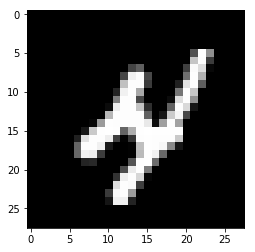

In [16]:
test = X_train[5891].reshape(-1, 28, 28, 1)
plt.imshow(X_train[5891, :, :, 0], cmap='gist_gray')

In [8]:
y_train.shape

(60000, 10)